# Modelling!

I will now dive into modelling the WNV cases using the datasets created in the previous Preprocessing notebook.  Hopefully I can improve upon the Logistic Regression model (especially the recall score) at the end of that notebook. 

Steps:
1.  Import data sets and modeling packages from sklearn. 
2. Try 3 different models, tune hyperparameters and evaluate each.  
    1. Random Forest
    2. XG Boost
    3. SVM
3. Select the best model and output the model. 

Import pandas numpy and all of the datasets.

In [2]:
random_seed = 27

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [4]:
y_train = pd.read_csv('y_train.csv',index_col=0).to_numpy().reshape(-1,)
y_test = pd.read_csv('y_test.csv',index_col=0).to_numpy().reshape(-1,)

### Note these are already standard scaled
X_train = pd.read_csv('X_train.csv',index_col=0).to_numpy()
X_test = pd.read_csv('X_test.csv',index_col=0).to_numpy()

X_train_pca95 = pd.read_csv('X_train_pca95.csv',index_col=0).to_numpy()
X_test_pca95 = pd.read_csv('X_test_pca95.csv',index_col=0).to_numpy()

X_train_nmf = pd.read_csv('X_train_nmf.csv',index_col=0).to_numpy()
X_test_nmf = pd.read_csv('X_test_nmf.csv',index_col=0).to_numpy()

Next a couple functions that will help in evaluating model performance and collecting the model metrics to help with selecting a model.

In [6]:
def Model_Eval(estimator,X_train,X_test,y_train,y_test):
    from sklearn.metrics import plot_confusion_matrix,precision_score,\
                                recall_score, plot_roc_curve
    import matplotlib.pyplot as plt
    
    fig,ax = plt.subplots(figsize=(5,5))
    plot_roc_curve(estimator,X_train,y_train,ax=ax,name='Train')
    plot_roc_curve(estimator,X_test,y_test,ax=ax,name='Test')
    plt.title('ROC curve')
    plt.show()

    fig,ax = plt.subplots(1,2,figsize=(10,5),tight_layout=True)
    plot_confusion_matrix(estimator,X_train,y_train,values_format='.4g',ax=ax[0],cmap='Blues')
    plot_confusion_matrix(estimator,X_test,y_test,values_format='.4g',ax=ax[1],cmap='Oranges')
    ax[0].set_title('Train')
    ax[1].set_title('Test')
    plt.show()

    ### Training
    print('Train Precision {:.3f}'.format(precision_score(\
                              y_train,estimator.predict(X_train))))
    print('Train Recall    {:.3f}'.format(recall_score(\
                               y_train,estimator.predict(X_train))))
    print()
    ### Testing
    print('Test Precision  {:.3f}'.format(precision_score(\
                              y_test,estimator.predict(X_test))))
    print('Test Recall     {:.3f}'.format(recall_score(\
                               y_test,estimator.predict(X_test))))

In [62]:
df_cols = ['Model','Train_AUC','Test_AUC','Train_prec','Train_recal','Test_prec','Test_recal']
scores_df=pd.DataFrame(columns=df_cols)

In [63]:
def agg_score_df(scores_df,estimator,name,X_train,X_test,y_train,y_test,\
                 df_cols=['Model','Train_AUC','Test_AUC','Train_prec',\
                          'Train_recal','Test_prec','Test_recal']):
    """
    """
    scores=[]
    scores.append(name)
    scores.append(roc_auc_score(y_train,estimator.predict(X_train)))
    scores.append(roc_auc_score(y_test,estimator.predict(X_test)))
    scores.append(precision_score(y_train,estimator.predict(X_train)))
    scores.append(recall_score(y_train,estimator.predict(X_train)))
    scores.append(precision_score(y_test,estimator.predict(X_test)))
    scores.append(recall_score(y_test,estimator.predict(X_test)))
    
    scores = np.array(scores).reshape(1,7)
    scores_df = pd.concat([scores_df,pd.DataFrame(scores,columns=df_cols)])

    return scores_df

Ready for modelling! First I will try a RandomForest classifier

# Random Forest Classifier

In [37]:
### import necessities from sklearn
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score, plot_confusion_matrix,\
                plot_precision_recall_curve, plot_roc_curve, make_scorer,\
                recall_score, precision_score, log_loss

That doesn't look great.  Without limiting the depths of the trees and without performing cross validation the model works perfectly on the training data! But it generalizes poorly to the testing data, high bias!
___
Next I will use GridSearchCV to perform a cross validation and tune the hyperparameters of the classifier. 

In [34]:
### Default Random Forest

rf_clf = RandomForestClassifier(random_state=random_seed)
rf_clf.fit(X_train,y_train)
print('Train AUC: {:.3f}'.format(roc_auc_score(y_train,rf_clf.predict(X_train))))
print('Test AUC: {:.3f}'.format(roc_auc_score(y_test,rf_clf.predict(X_test))))

Train AUC: 1.000
Test AUC: 0.610


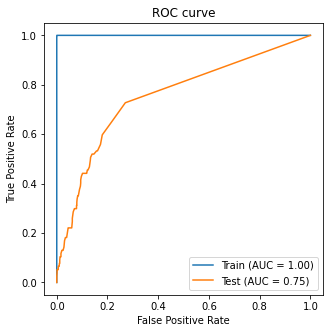

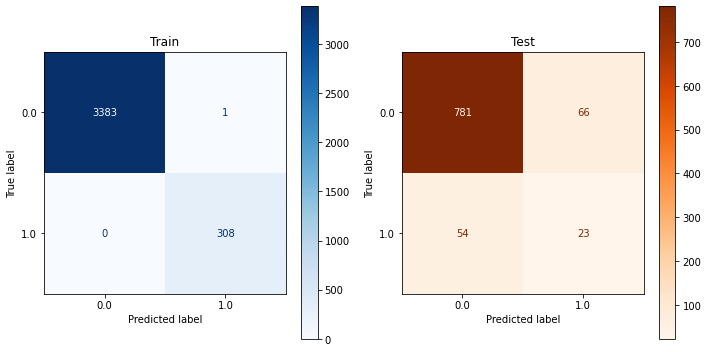

Train Precision 0.997
Train Recall    1.000

Test Precision  0.258
Test Recall     0.299


In [35]:
Model_Eval(rf_clf,X_train,X_test,y_train,y_test)

Clearly overfit.  But I will start aggregating the scores to in a dataframe to make it easier to decide which is the best model.  

In [64]:
scores_df = agg_score_df(scores_df,rf_clf,'RandomForest default',X_train,X_test,y_train,y_test)
scores_df.tail()

,Model,Train_AUC,Test_AUC,Train_prec,Train_recal,Test_prec,Test_recal
0,RandomForest default,0.9998522458628842,0.6103896103896104,0.9967637540453075,1.0,0.25842696629213485,0.2987012987012987


In [26]:
for i in RandomForestClassifier().get_params().keys():print(i)

bootstrap
ccp_alpha
class_weight
criterion
max_depth
max_features
max_leaf_nodes
max_samples
min_impurity_decrease
min_impurity_split
min_samples_leaf
min_samples_split
min_weight_fraction_leaf
n_estimators
n_jobs
oob_score
random_state
verbose
warm_start


In [65]:
### define grid parameters and fit model

params={'n_estimators':[50,80,100,120,150],\
       'criterion': ['gini','entropy'],\
       'max_depth':[3,5,7,9],
       'class_weight':['balanced'],\
       'random_state': [random_seed]}

rf_clf = RandomForestClassifier()

grid_rf_clf = GridSearchCV(rf_clf,param_grid=params,cv=5,n_jobs=-1,\
                           scoring=make_scorer(roc_auc_score))

grid_rf_clf.fit(X_train,y_train)

print('Best Params: ',grid_rf_clf.best_params_)
print('Best Score: ',grid_rf_clf.best_score_)

Best Params:  {'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': 9, 'n_estimators': 100, 'random_state': 27}
Best Score:  0.7670000502137729


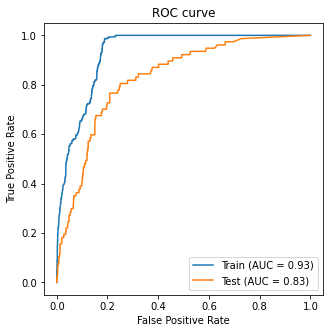

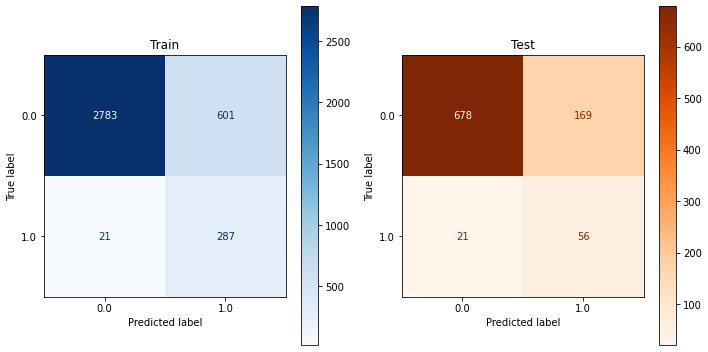

Train Precision 0.323
Train Recall    0.932

Test Precision  0.249
Test Recall     0.727


In [66]:
Model_Eval(grid_rf_clf,X_train,X_test,y_train,y_test)

That looks better but I am a little concerned about the large difference in the training and testing AUC's and in the two recall scores.  The model might be a litter overcomplicated and not generalizing well.  Maybe I should try to decrease the `max_depth` of the individual trees.  Recall has increased dramatically over the logistic regression model in the previous notebook. Unfortunately precision has fallen to quite a low value. Lets look at the precision-recall plot.

Lets look at the precision-recall plot.

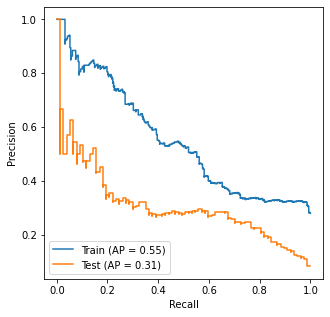

In [67]:
fig,ax = plt.subplots(figsize=(5,5))
plot_precision_recall_curve(grid_rf_clf,X_train,y_train,ax=ax,name='Train')
plot_precision_recall_curve(grid_rf_clf,X_test,y_test,ax=ax,name='Test')
plt.show()


This is not ideal.  This plot again shows the model does not generalize well. Now I will try the same exercise above but using the PCA reduced features.  

In [68]:
scores_df = agg_score_df(scores_df,grid_rf_clf,'RandomForest tuned',X_train,X_test,y_train,y_test)
scores_df.tail()

,Model,Train_AUC,Test_AUC,Train_prec,Train_recal,Test_prec,Test_recal
0,RandomForest default,0.9998522458628842,0.6103896103896104,0.9967637540453075,1.0,0.25842696629213485,0.2987012987012987
0,RandomForest tuned,0.8771088545024714,0.7638724911452184,0.32319819819819817,0.9318181818181818,0.24888888888888888,0.7272727272727273


The tuned model is much better, but why is `roc_auc_score` different than what is show in the `plot_roc_curve` function?
___
To mitigate overfitting I will try using the PCA transformed features. 

In [69]:
### define grid parameters and fit model

params={'n_estimators':[50,80,100,120,150],\
       'criterion': ['gini','entropy'],\
       'max_depth':[3,5,7,9],
       'class_weight':[None,'balanced'],\
       'random_state': [random_seed]}

rf_clf = RandomForestClassifier()

grid_rf_clf = GridSearchCV(rf_clf,param_grid=params,cv=5,n_jobs=-1,\
                           scoring=make_scorer(roc_auc_score),\
                          )

grid_rf_clf.fit(X_train_pca95,y_train)

print('Best Params: ',grid_rf_clf.best_params_)
print('Best Score: ',grid_rf_clf.best_score_)

Best Params:  {'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': 5, 'n_estimators': 50, 'random_state': 27}
Best Score:  0.760899751844403


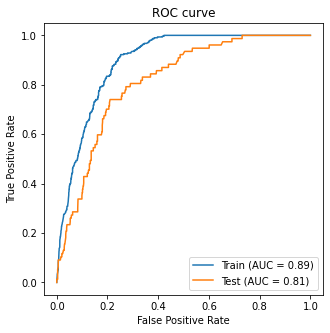

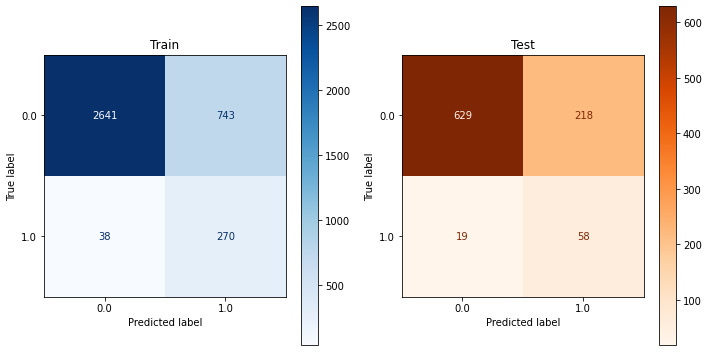

Train Precision 0.267
Train Recall    0.877

Test Precision  0.210
Test Recall     0.753


In [70]:
Model_Eval(grid_rf_clf,X_train_pca95,X_test_pca95,y_train,y_test)

The PCA dataset contains the top 15 PCA components, that explain 95% of the variance in the dataset.  The PCA trained random forest has a slightly lower AUC score but a higher test recall, which suggests it is less biased than the previous model trained on the full dataset.  

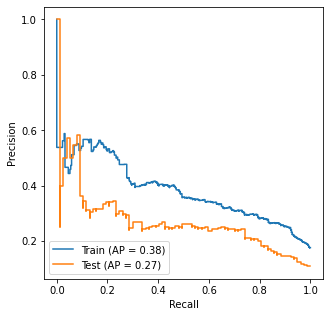

In [71]:
fig,ax = plt.subplots(figsize=(5,5))
plot_precision_recall_curve(grid_rf_clf,X_train_pca95,y_train,ax=ax,name='Train')
plot_precision_recall_curve(grid_rf_clf,X_test_pca95,y_test,ax=ax,name='Test')
plt.show()


In [72]:
scores_df = agg_score_df(scores_df,grid_rf_clf,'RandomForest PCA',X_train_pca95,X_test_pca95,y_train,y_test)
scores_df.tail()

,Model,Train_AUC,Test_AUC,Train_prec,Train_recal,Test_prec,Test_recal
0,RandomForest default,0.9998522458628842,0.6103896103896104,0.9967637540453075,1.0,0.25842696629213485,0.2987012987012987
0,RandomForest tuned,0.8771088545024714,0.7638724911452184,0.32319819819819817,0.9318181818181818,0.24888888888888888,0.7272727272727273
0,RandomForest PCA,0.8285303644346197,0.7479338842975206,0.2665350444225074,0.8766233766233766,0.21014492753623187,0.7532467532467533


# Boosted Decision trees

In [75]:
### Import gradient boost and xgboost
from sklearn.ensemble import GradientBoostingClassifier



First I will try the Gradient Boosting classifier from sklearn, starting with the default model. 

In [92]:

params={'learning_rate':[0.1]}

gb_clf = GradientBoostingClassifier(random_state=random_seed)
grid_gb_clf = GridSearchCV(gb_clf,param_grid=params,cv=5,\
                           scoring = make_scorer(roc_auc_score))
grid_gb_clf.fit(X_train,y_train)

print('Train AUC: ', roc_auc_score(y_train,grid_gb_clf.predict(X_train)))
print('Test AUC: ', roc_auc_score(y_test,grid_gb_clf.predict(X_test)))



Train AUC:  0.6050742992232353
Test AUC:  0.5720188902007084


In [98]:
roc_auc_score(y_train,grid_gb_clf.predict_proba(X_train)[:,1])

0.9281905299192533

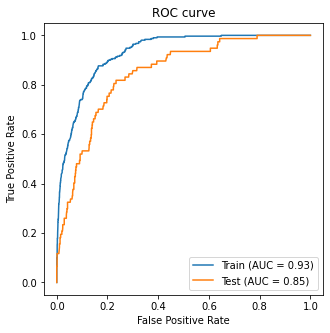

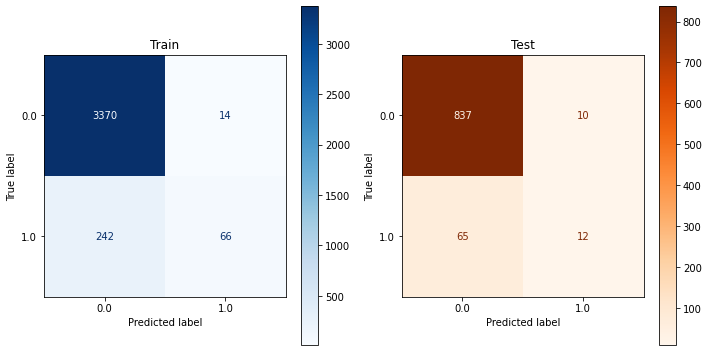

Train Precision 0.825
Train Recall    0.214

Test Precision  0.545
Test Recall     0.156


In [94]:
Model_Eval(grid_gb_clf,X_train,X_test,y_train,y_test)

In [83]:
scores_df = agg_score_df(scores_df,gb_clf,'Gradient Boost default',X_train,X_test,y_train,y_test)
scores_df.tail()

,Model,Train_AUC,Test_AUC,Train_prec,Train_recal,Test_prec,Test_recal
0,RandomForest default,0.9998522458628842,0.6103896103896104,0.9967637540453075,1.0,0.25842696629213485,0.2987012987012987
0,RandomForest tuned,0.8771088545024714,0.7638724911452184,0.32319819819819817,0.9318181818181818,0.24888888888888888,0.7272727272727273
0,RandomForest PCA,0.8285303644346197,0.7479338842975206,0.2665350444225074,0.8766233766233766,0.21014492753623187,0.7532467532467533
0,Gradient Boost default,0.6050742992232353,0.5720188902007084,0.825,0.21428571428571427,0.5454545454545454,0.15584415584415584


The AUC's look pretty good, but the recall is very low.  The model needs to do a better recall score so we it doesn't miss a lot of positive WNV cases.  Now I will try to tune the model.     

In [76]:
### Gradient Boosting Classifier parameters
for i in GradientBoostingClassifier().get_params().keys():print(i)

ccp_alpha
criterion
init
learning_rate
loss
max_depth
max_features
max_leaf_nodes
min_impurity_decrease
min_impurity_split
min_samples_leaf
min_samples_split
min_weight_fraction_leaf
n_estimators
n_iter_no_change
presort
random_state
subsample
tol
validation_fraction
verbose
warm_start


In [84]:
### Gradient boosting model
params = {'max_depth':[2,3,5],\
         'learning_rate':[0.1,0.5,0.8,1],\
         'n_estimators':[20,40,80],\
          'max_features':[.5,.8,1],\
         'subsample':[.5,.8,1]}


gb_clf = GradientBoostingClassifier(random_state=random_seed)
grid_gb_clf = GridSearchCV(gb_clf,param_grid=params,cv=5,n_jobs=-1,\
                           scoring=make_scorer(roc_auc_score))
grid_gb_clf.fit(X_train,y_train)
print('Best Params: ',grid_gb_clf.best_params_)
print('Best Score: ',grid_gb_clf.best_score_)


Best Params:  {'learning_rate': 0.8, 'max_depth': 5, 'max_features': 0.5, 'n_estimators': 40, 'subsample': 0.5}
Best Score:  0.6367245401045374


That took much longer than the random forest, the ensemble is done in series after all.  

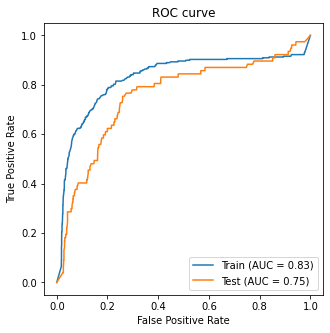

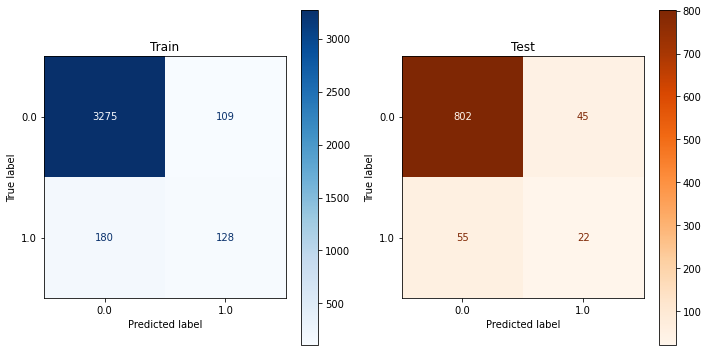

Train Precision 0.540
Train Recall    0.416

Test Precision  0.328
Test Recall     0.286


In [90]:
Model_Eval(grid_gb_clf,X_train,X_test,y_train,y_test)

Wow the training AUC is very high, but it is a big step down to the test AUC.  It looks like the model is very over fitted to the training data. The confusion matrix also shows that the model is overfit to the training data (High bias). I will try it again using the PCA transformed data. 

In [134]:
### Gradient boosting model using PCA transformed data
params = {'max_depth':[3,5],\
         'learning_rate':[0.5,0.7,0.85,1],\
         'n_estimators':[50,100],\
         'subsample':[.5,.7,.9]}


gb_clf = GradientBoostingClassifier(random_state=random_seed)
grid_gb_clf = GridSearchCV(gb_clf,param_grid=params,cv=3,n_jobs=-1,\
                           scoring=make_scorer(roc_auc_score))
grid_gb_clf.fit(X_train_pca95,y_train)
print('Best Params: ',grid_gb_clf.best_params_)
print('Best Score: ',grid_gb_clf.best_score_)


Best Params:  {'learning_rate': 0.5, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.9}
Best Score:  0.6177208093180121


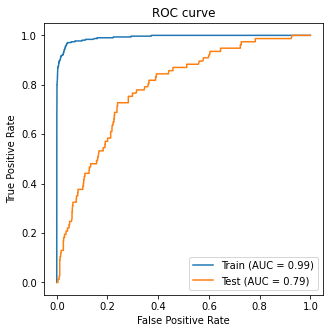

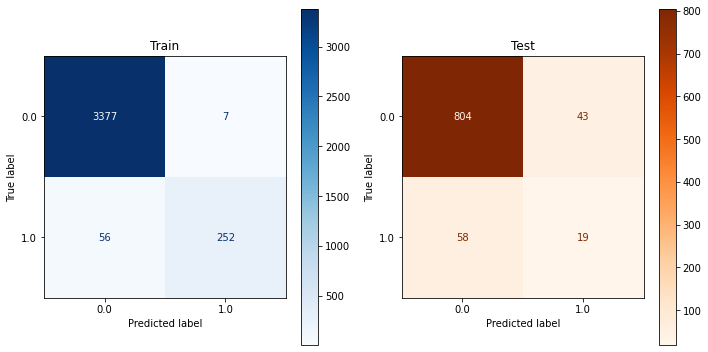

Train Precision 0.973
Train Recall    0.818

Test Precision  0.306
Test Recall     0.247


In [135]:
Model_Eval(grid_gb_clf,X_train_pca95,X_test_pca95,y_train,y_test)

Using the PCA transformed dataset produced an even more biased model.  I will revisit the previous model and attempt additional tuning. 

# Ask Rahul about tuning the GB model

In [148]:
### Gradient boosting model
params = {'max_depth':[3,5,7],\
         'learning_rate':[0.01,0.1,0.25,.5,1],\
         'n_estimators':[5,10,20,40],\
          }


gb_clf = GradientBoostingClassifier(random_state=random_seed)
grid_gb_clf = GridSearchCV(gb_clf,param_grid=params,cv=4,n_jobs=-1,\
                           scoring=make_scorer(roc_auc_score))
grid_gb_clf.fit(X_train,y_train)
print('Best Params: ',grid_gb_clf.best_params_)
print('Best Score: ',grid_gb_clf.best_score_)


Best Params:  {'learning_rate': 1, 'max_depth': 7, 'n_estimators': 10}
Best Score:  0.6112415952841485


In [149]:
#for i in grid_gb_clf.cv_results_['params']: print(i)
#print()
#for i in grid_gb_clf.cv_results_['mean_test_score']: print(i)

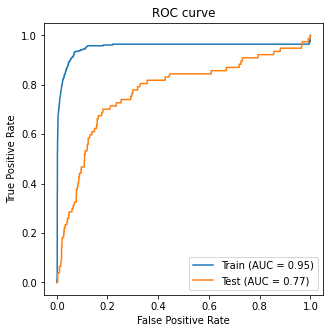

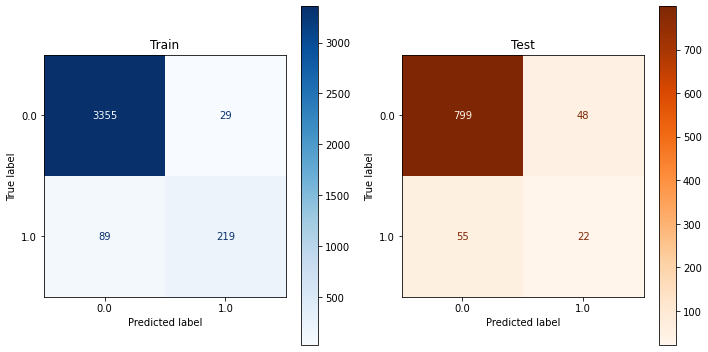

Train Precision 0.883
Train Recall    0.711

Test Precision  0.314
Test Recall     0.286


In [150]:
Model_Eval(grid_gb_clf,X_train,X_test,y_train,y_test)

## XG Boost

In [54]:
import xgboost

In [155]:
### try XG Boost using default parameters

### Transform to dmatrix (I forget why...)
data_dmatrix = xgboost.DMatrix(data=X_train,label=y_train)

### Set basic parameters, No tuning yet!!
params = {'objective':['binary:logistic'],'eval_metric':['auc']}

grid_xgb = GridSearchCV(xgboost.XGBClassifier(),param_grid=params,cv=3)
#xgb = xgboost.XGBClassifier(objective = 'binary:logistic',\
                            #eval_metric = 'auc')

grid_xgb.fit(X_train,y_train)

print('Best Params: ',grid_xgb.best_params_)


C:\Users\blain\Anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Best Params:  {'eval_metric': 'auc', 'objective': 'binary:logistic'}


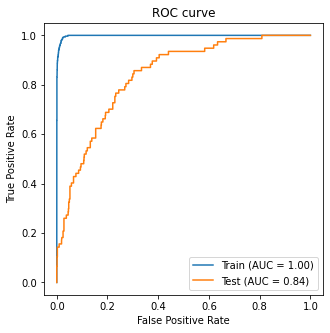

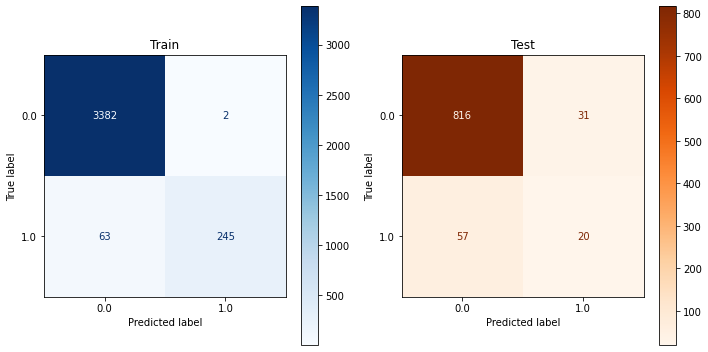

Train Precision 0.992
Train Recall    0.795

Test Precision  0.392
Test Recall     0.260


In [156]:
Model_Eval(grid_xgb,X_train,X_test,y_train,y_test)

The default XGB model is overfitted and generalizes very poorly to the testing set.  I will now attempt to tune the parameters.  


In [72]:
for i in xgboost.XGBClassifier().get_params().keys(): print(i)

objective
use_label_encoder
base_score
booster
colsample_bylevel
colsample_bynode
colsample_bytree
gamma
gpu_id
importance_type
interaction_constraints
learning_rate
max_delta_step
max_depth
min_child_weight
missing
monotone_constraints
n_estimators
n_jobs
num_parallel_tree
random_state
reg_alpha
reg_lambda
scale_pos_weight
subsample
tree_method
validate_parameters
verbosity


In [167]:
### Grid search to prevent overfitting XG Boost

### Transform to dmatrix (I forget why...)
data_dmatrix = xgboost.DMatrix(data=X_train,label=y_train)

### Set basic parameters, No tuning yet!!
params = {'objective':['binary:logistic'],'eval_metric':['auc'],\
         'subsample':[0.5,0.8,1],\
         'colsample_bytree':[0.5,0.8,1],\
         'gamma':[1,10], 'alpha':[1,10,100], 'lambda':[.1,1,10],\
         'learning_rate':[.001,.01,.1]}

grid_xgb = GridSearchCV(xgboost.XGBClassifier(),param_grid=params,cv=3)
#xgb = xgboost.XGBClassifier(objective = 'binary:logistic',\
                            #eval_metric = 'auc')

grid_xgb.fit(X_train,y_train)


print('Best Params: ',grid_xgb.best_params_)
print('Best Score: ',grid_xgb.best_score_)

C:\Users\blain\Anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Best Params:  {'alpha': 1, 'colsample_bytree': 0.5, 'eval_metric': 'auc', 'gamma': 1, 'lambda': 0.1, 'learning_rate': 0.1, 'objective': 'binary:logistic', 'subsample': 0.5}
Best Score:  0.9203676918978775


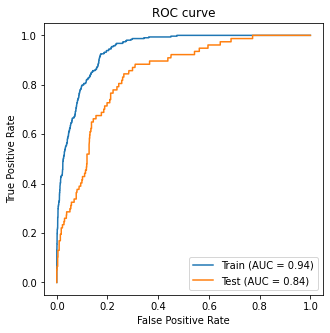

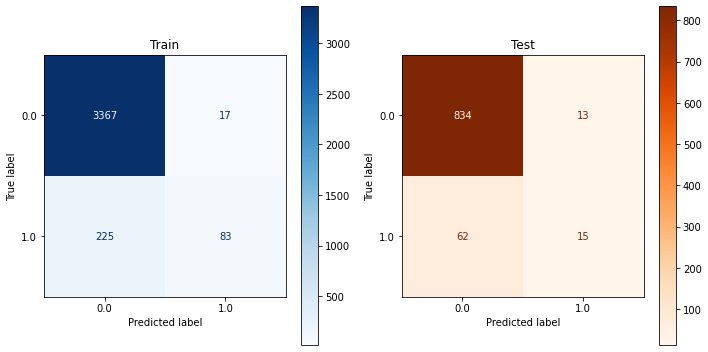

Train Precision 0.830
Train Recall    0.269

Test Precision  0.536
Test Recall     0.195


In [168]:
Model_Eval(grid_xgb,X_train,X_test,y_train,y_test)

This looks a little better.  The test AUC is the same as before, but in this tuned model it is steeper.  This model applied to the test set has greater precision, but lower recall.  
___
Now I will try the XGBoost model with the PCA transformed features. Maybe reducing the features will help overfitting.

In [173]:
### Grid search to prevent overfitting XG Boost

### Transform to dmatrix (I forget why...)
data_dmatrix = xgboost.DMatrix(data=X_train,label=y_train)

### Set basic parameters, No tuning yet!!
params = {'objective':['binary:logistic'],'eval_metric':['logloss'],\
         'subsample':[0.5,0.8,1],\
         'colsample_bytree':[0.5,0.8,1],\
         'gamma':[1,10], 'alpha':[1,10,100], 'lambda':[.1,1,10],\
         'learning_rate':[.001,.01,.1]}

grid_xgb = GridSearchCV(xgboost.XGBClassifier(),param_grid=params,cv=3)


grid_xgb.fit(X_train_pca95,y_train)


print('Best Params: ',grid_xgb.best_params_)
print('Best Score: ',grid_xgb.best_score_)

C:\Users\blain\Anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Best Params:  {'alpha': 1, 'colsample_bytree': 1, 'eval_metric': 'logloss', 'gamma': 1, 'lambda': 1, 'learning_rate': 0.01, 'objective': 'binary:logistic', 'subsample': 0.8}
Best Score:  0.9187434368251074


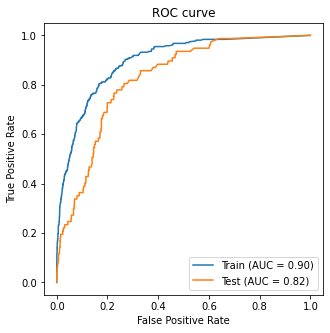

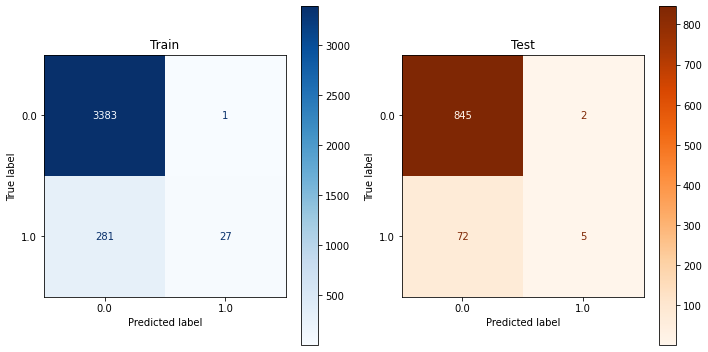

Train Precision 0.964
Train Recall    0.088

Test Precision  0.714
Test Recall     0.065


In [174]:
Model_Eval(grid_xgb,X_train_pca95,X_test_pca95,y_train,y_test)

Looking at the ROC curve I thought this model was pretty good, but the recall values are terrible. I should discuss these results with Rahul to see how they can be improved. 

# Support Vector Machine

In [8]:
from sklearn.svm import SVC

In [9]:
### try default Support vector classifier

params={'C':[1]}

svc = SVC(random_state=random_seed)

grid_svc = GridSearchCV(svc,param_grid=params,cv=5,n_jobs=-1,\
                       scoring = make_scorer(roc_auc_score))

grid_svc.fit(X_train,y_train)

print('Best Params: ',grid_svc.best_params_)
print('Best Score; ',grid_svc.best_score_)

Best Params:  {'C': 1}
Best Score;  0.5


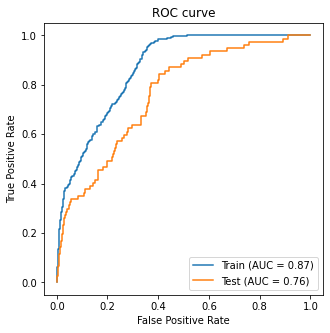

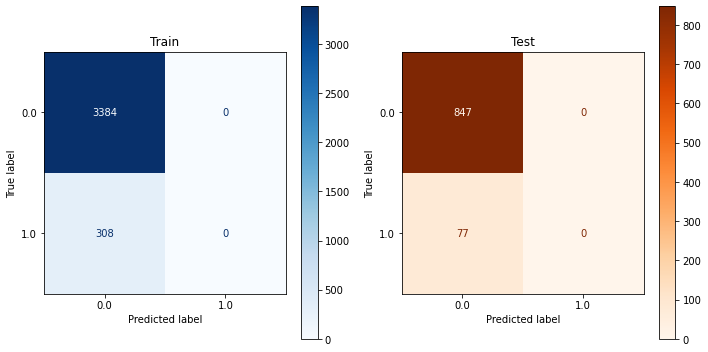

C:\Users\blain\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Precision 0.000
Train Recall    0.000

Test Precision  0.000
Test Recall     0.000


C:\Users\blain\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [10]:
Model_Eval(grid_svc,X_train,X_test,y_train,y_test)

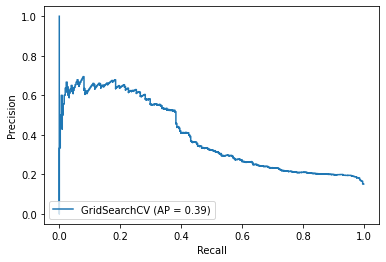

In [11]:
plot_precision_recall_curve(grid_svc,X_train,y_train)

That is not ideal.  I will attempt some hyperparameter tuning.

In [16]:
### try default Support vector classifier

params={'C':[.8,1,1.2,1.5], 'kernel':['rbf','linear'],\
        'gamma':['scale','auto'], 'class_weight':['balanced']}

svc = SVC(random_state=random_seed,probability=True)

grid_svc = GridSearchCV(svc,param_grid=params,cv=5,n_jobs=-1,\
                        scoring=make_scorer(roc_auc_score))

grid_svc.fit(X_train,y_train)

print('Best Params: ',grid_svc.best_params_)
print('Best Score; ',grid_svc.best_score_)

Best Params:  {'C': 1.5, 'class_weight': 'balanced', 'gamma': 'scale', 'kernel': 'rbf'}
Best Score;  0.7752645296133531


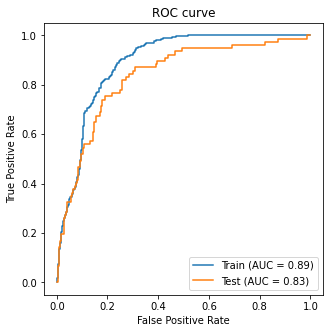

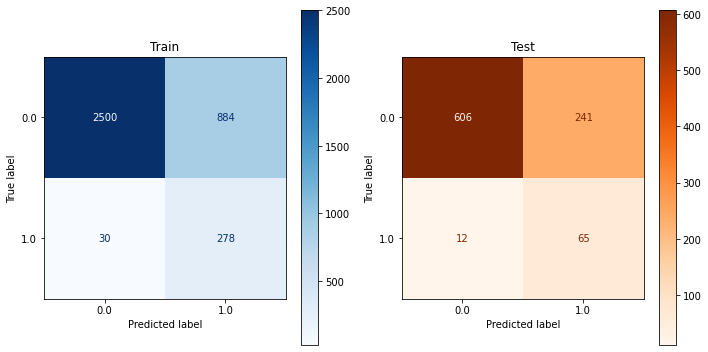

Train Precision 0.239
Train Recall    0.903

Test Precision  0.212
Test Recall     0.844


In [17]:
Model_Eval(grid_svc,X_train,X_test,y_train,y_test)

It appears changing the `class_weight` parameter to balanced really helped the training process.  Weight is added to the positive cases to make up for their small presence in the data set.

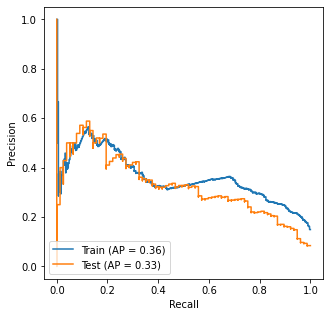

In [18]:
fig,ax = plt.subplots(figsize=(5,5))
plot_precision_recall_curve(grid_svc,X_train,y_train,ax=ax,name='Train')
plot_precision_recall_curve(grid_svc,X_test,y_test,ax=ax,name='Test')
plt.show()


I like this model.  The model doesn't appear overfit to the training data and the AUC is high with high recall instead of high precision.  